## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -2.989824     551.514698   -19.194445     -28.116538   
1            2     -2.989824     551.514698   -19.194445     -28.116538   
2            3     -2.989824     551.514698   -19.194445     -28.116538   
3            4     -2.989824     551.514698   -19.194445     -28.116538   
4            5     -2.989824     551.514698   -19.194445     -28.116538   
...        ...           ...            ...          ...            ...   
2628545     46    -12.920028     494.226632   -46.982710     -95.220702   
2628546     47    -12.920028     494.226632   -46.982710     -95.220702   
2628547     48    -12.920028     494.226632   -46.982710     -95.220702   
2628548     49    -12.920028     494.226632   -46.982710     -95.220702   
2628549     50    -12.920028     494.226632   -46.982710     -95.220702   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 52571
Number of training points: 1577100


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_conv04']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC',   'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 'Uw',
                 'day_of_year', 'time_of_day'] #,  
               #  'buoyancy', 'diffusivity', 'temp_initial00', 
               # 'temp_heat01', 'temp_diff02', 'temp_total05',
               # 'ice', 'snow', 'snowice'
m0_output_columns = ['obs_temp']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./saved_models/direct_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32,32,32,32,32,32,32,32,32, len(m0_output_columns)]

direct_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
direct_model.load_state_dict(m0_checkpoint)
direct_model = direct_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

## Mixing Model

# Convection Model

# Ice Model

In [9]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [10]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [11]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [12]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [13]:
print(train_data.shape)
print(test_data.shape)

(1577100, 45)
(1051450, 45)


In [14]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [15]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [16]:
def get_rollout_predictions(direct_model, loader, plot = True):    
    direct_model.eval()

    mean = torch.tensor(train_mean[m0_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m0_output_column_ix]).float().to(device)


#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = direct_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        y_true = x[:, m0_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m0_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [17]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [18]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(direct_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.5612874
RMSE of after m0 0.64478093
RMSE of after m0 0.49986994
RMSE of after m0 0.5437196
RMSE of after m0 0.6996587
RMSE of after m0 0.9538796
RMSE of after m0 0.4492876
RMSE of after m0 0.34942305
RMSE of after m0 0.5572707
RMSE of after m0 0.77540797
RMSE of after m0 0.63779056
RMSE of after m0 0.8968444
RMSE of after m0 0.5837832
RMSE of after m0 0.77629143
RMSE of after m0 0.936056
RMSE of after m0 0.6417389
RMSE of after m0 0.87324935
RMSE of after m0 0.6082578
RMSE of after m0 1.1659293
RMSE of after m0 0.9955471
RMSE of after m0 0.79984975
RMSE of after m0 0.8361395
RMSE of after m0 0.9445215
RMSE of after m0 0.86406827
RMSE of after m0 0.5306851
RMSE of after m0 0.602562
RMSE of after m0 0.88032615
RMSE of after m0 0.76384497
RMSE of after m0 0.65195554
RMSE of after m0 0.60984766
RMSE of after m0 0.4766002
RMSE of after m0 0.6014365
RMSE of after m0 0.5856751
RMSE of after m0 0.7022326
RMSE of after m0 0.6825412
RMSE of after m0 0.9462682
RMSE of after m0 

RMSE of after m0 1.3379116
RMSE of after m0 0.9684248
RMSE of after m0 0.6531222
RMSE of after m0 1.2647061
RMSE of after m0 0.63690794
RMSE of after m0 0.86786765
RMSE of after m0 1.8763739
RMSE of after m0 0.6615912
RMSE of after m0 0.58135444
RMSE of after m0 0.55829525
RMSE of after m0 1.6236537
RMSE of after m0 1.0932267
RMSE of after m0 0.8695313
RMSE of after m0 0.70622784
RMSE of after m0 0.6153286
RMSE of after m0 0.5349948
RMSE of after m0 0.5650254
RMSE of after m0 1.0344901
RMSE of after m0 1.2430393
RMSE of after m0 0.57952446
RMSE of after m0 0.96000695
RMSE of after m0 0.7306597
RMSE of after m0 0.5505329
RMSE of after m0 0.84141296
RMSE of after m0 0.5627078
RMSE of after m0 0.49721694
RMSE of after m0 0.65161026
RMSE of after m0 0.87128633
RMSE of after m0 1.0437937
RMSE of after m0 0.9702071
RMSE of after m0 1.3112048
RMSE of after m0 0.8590815
RMSE of after m0 0.34324965
RMSE of after m0 0.6206455
RMSE of after m0 0.96827286
RMSE of after m0 0.75355214
RMSE of after 

RMSE of after m0 1.2790457
RMSE of after m0 0.6945762
RMSE of after m0 0.92114216
RMSE of after m0 0.96674204
RMSE of after m0 1.1196823
RMSE of after m0 1.1618822
RMSE of after m0 0.95559186
RMSE of after m0 0.7399435
RMSE of after m0 0.72468966
RMSE of after m0 1.02715
RMSE of after m0 0.7032408
RMSE of after m0 0.72618866
RMSE of after m0 0.83782566
RMSE of after m0 1.1613884
RMSE of after m0 1.0105348
RMSE of after m0 1.0177761
RMSE of after m0 0.818659
RMSE of after m0 1.1338441
RMSE of after m0 0.93172985
RMSE of after m0 0.95847875
RMSE of after m0 1.0264822
RMSE of after m0 0.9716235
RMSE of after m0 0.73525834
RMSE of after m0 0.88333243
RMSE of after m0 1.0349512
RMSE of after m0 1.0487953
RMSE of after m0 1.0725071
RMSE of after m0 0.9978454
RMSE of after m0 1.1906987
RMSE of after m0 1.0553833
RMSE of after m0 1.0949825
RMSE of after m0 0.7557717
RMSE of after m0 0.85471874
RMSE of after m0 0.72222537
RMSE of after m0 0.9119637
RMSE of after m0 0.90454865
RMSE of after m0 1

RMSE of after m0 0.4114824
RMSE of after m0 0.47731662
RMSE of after m0 0.41438115
RMSE of after m0 0.45022652
RMSE of after m0 0.37433073
RMSE of after m0 0.25191277
RMSE of after m0 0.4429756
RMSE of after m0 0.31401363
RMSE of after m0 0.28945044
RMSE of after m0 0.4074428
RMSE of after m0 0.35837075
RMSE of after m0 0.5953131
RMSE of after m0 0.42750126
RMSE of after m0 0.4429508
RMSE of after m0 0.61104965
RMSE of after m0 0.59684765
RMSE of after m0 0.55879647
RMSE of after m0 0.54003924
RMSE of after m0 0.3889009
RMSE of after m0 0.5719422
RMSE of after m0 0.6203648
RMSE of after m0 0.46078902
RMSE of after m0 0.35379556
RMSE of after m0 0.41256475
RMSE of after m0 0.5319337
RMSE of after m0 0.5863889
RMSE of after m0 0.51498115
RMSE of after m0 0.51190794
RMSE of after m0 0.5802392
RMSE of after m0 0.4771489
RMSE of after m0 0.37590757
RMSE of after m0 0.7000839
RMSE of after m0 0.37883857
RMSE of after m0 0.44137824
RMSE of after m0 0.46631992
RMSE of after m0 0.55799586
RMSE 

RMSE of after m0 0.5216036
RMSE of after m0 0.6721164
RMSE of after m0 0.5836166
RMSE of after m0 0.5235049
RMSE of after m0 0.74632496
RMSE of after m0 0.6806256
RMSE of after m0 0.82396483
RMSE of after m0 0.8719406
RMSE of after m0 0.66423124
RMSE of after m0 0.7673503
RMSE of after m0 0.7008287
RMSE of after m0 0.33491653
RMSE of after m0 0.34979826
RMSE of after m0 0.3066771
RMSE of after m0 0.29396978
RMSE of after m0 0.33435747
RMSE of after m0 0.27504653
RMSE of after m0 0.27635178
RMSE of after m0 0.31639132
RMSE of after m0 0.29261923
RMSE of after m0 0.273569
RMSE of after m0 0.52098346
RMSE of after m0 0.6580433
RMSE of after m0 0.46553546
RMSE of after m0 0.5546769
RMSE of after m0 0.40172213
RMSE of after m0 0.41947934
RMSE of after m0 0.86349356
RMSE of after m0 0.27529275
RMSE of after m0 1.1290171
RMSE of after m0 1.0177344
RMSE of after m0 0.56028694
RMSE of after m0 0.29254928
RMSE of after m0 0.30696473
RMSE of after m0 0.3393515
RMSE of after m0 0.28185508
RMSE of 

RMSE of after m0 1.0346483
RMSE of after m0 1.1463747
RMSE of after m0 1.2435304
RMSE of after m0 1.162795
RMSE of after m0 1.609726
RMSE of after m0 1.2206216
RMSE of after m0 1.6091204
RMSE of after m0 1.3274328
RMSE of after m0 1.1655072
Train RMSE Simulated: 0.8347979187965393
Train RMSE Observed Temp: 0.8347979187965393
Train L2 Error: 0.07299821078777313
The RMSEs after each modelling stage: [0.75105342 0.         0.         0.         0.        ]


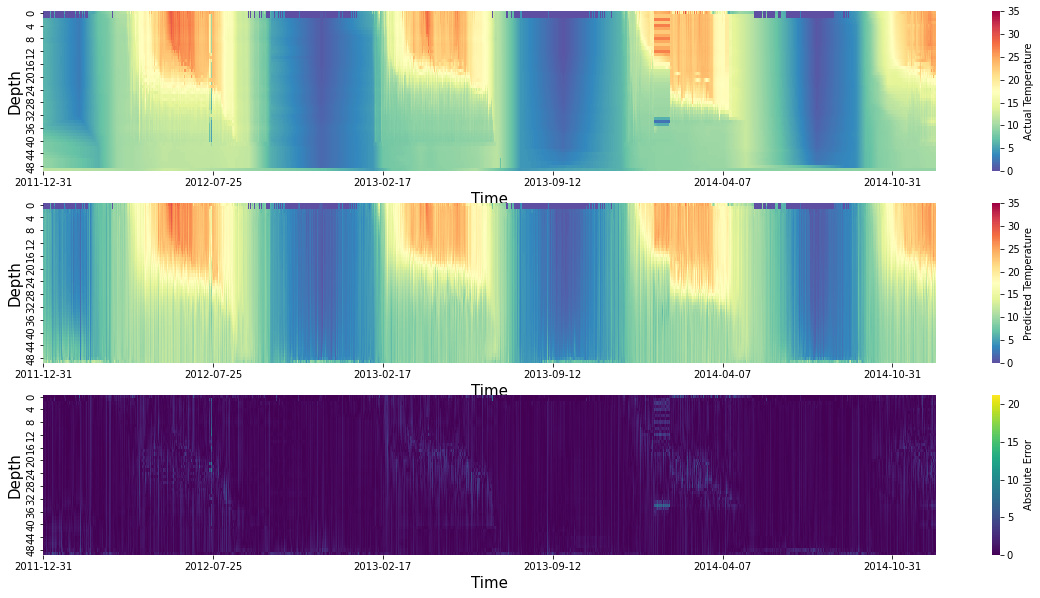

In [19]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

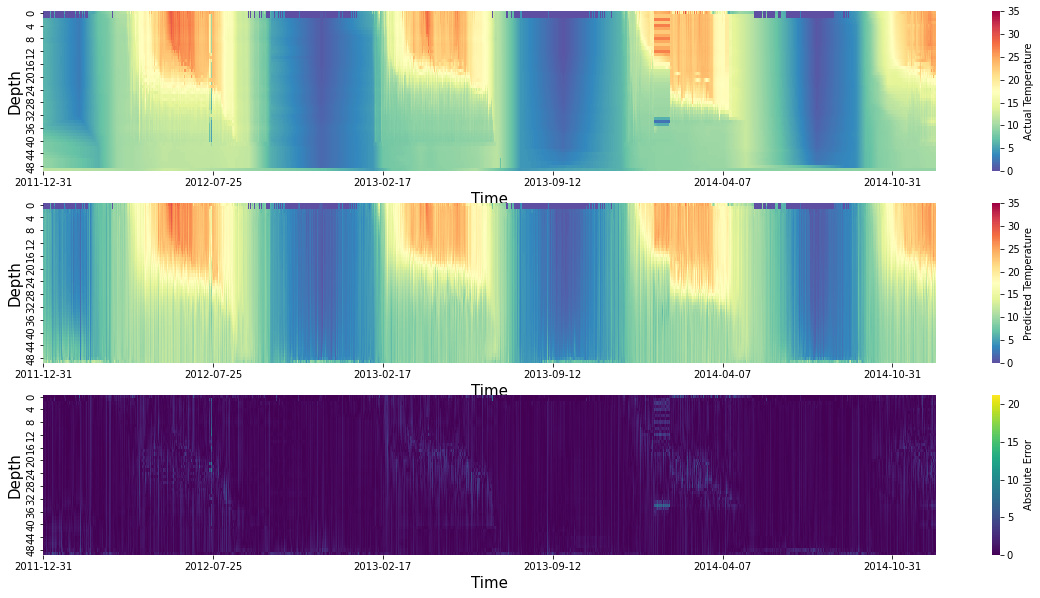

In [20]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [21]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(direct_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 1.2665288
RMSE of after m0 1.2624172
RMSE of after m0 1.6530988
RMSE of after m0 1.5404823
RMSE of after m0 1.5767542
RMSE of after m0 1.6300117
RMSE of after m0 1.74673
RMSE of after m0 2.0513525
RMSE of after m0 1.6730034
RMSE of after m0 2.0191243
RMSE of after m0 1.837896
RMSE of after m0 2.5352352
RMSE of after m0 2.304104
RMSE of after m0 2.3796465
RMSE of after m0 2.331871
RMSE of after m0 1.8701276
RMSE of after m0 3.7297668
RMSE of after m0 3.5758474
RMSE of after m0 2.9055796
RMSE of after m0 3.2970936
RMSE of after m0 4.01812
RMSE of after m0 4.7654805
RMSE of after m0 5.3477325
RMSE of after m0 4.185578
RMSE of after m0 2.201013
RMSE of after m0 2.4509702
RMSE of after m0 2.2510972
RMSE of after m0 3.5746205
RMSE of after m0 2.3516343
RMSE of after m0 1.9845145
RMSE of after m0 2.2199337
RMSE of after m0 2.7443385
RMSE of after m0 2.4711792
RMSE of after m0 2.4670832
RMSE of after m0 4.4698296
RMSE of after m0 3.0179892
RMSE of after m0 3.1165009
RMSE of af

RMSE of after m0 3.7359
RMSE of after m0 3.161902
RMSE of after m0 3.0502167
RMSE of after m0 2.630015
RMSE of after m0 3.655311
RMSE of after m0 2.721023
RMSE of after m0 2.3226392
RMSE of after m0 2.1209757
RMSE of after m0 3.2047424
RMSE of after m0 2.800932
RMSE of after m0 1.9531614
RMSE of after m0 1.7773315
RMSE of after m0 1.8276302
RMSE of after m0 2.0857313
RMSE of after m0 1.3405194
RMSE of after m0 1.4114969
RMSE of after m0 1.1927912
RMSE of after m0 2.8007133
RMSE of after m0 2.0446208
RMSE of after m0 2.187716
RMSE of after m0 1.5739379
RMSE of after m0 1.6947486
RMSE of after m0 1.4647415
RMSE of after m0 1.3617284
RMSE of after m0 1.6304489
RMSE of after m0 1.3636928
RMSE of after m0 2.0736802
RMSE of after m0 1.6680728
RMSE of after m0 1.529409
RMSE of after m0 1.213305
RMSE of after m0 1.6132537
RMSE of after m0 1.7835923
RMSE of after m0 0.9531178
RMSE of after m0 1.3661609
RMSE of after m0 1.883454
RMSE of after m0 1.3138802
RMSE of after m0 1.8004651
RMSE of after

RMSE of after m0 1.7961498
RMSE of after m0 0.998335
RMSE of after m0 0.5848701
RMSE of after m0 1.6425573
RMSE of after m0 1.9221265
RMSE of after m0 1.5301349
RMSE of after m0 1.8785784
RMSE of after m0 0.56254417
RMSE of after m0 0.70583326
RMSE of after m0 0.8840318
RMSE of after m0 1.5170658
RMSE of after m0 2.076199
RMSE of after m0 1.505867
RMSE of after m0 1.3915977
RMSE of after m0 1.4221662
RMSE of after m0 2.0947244
RMSE of after m0 1.7450887
RMSE of after m0 1.4471116
RMSE of after m0 1.0094483
RMSE of after m0 1.3602666
RMSE of after m0 1.8679342
RMSE of after m0 1.0816193
RMSE of after m0 0.7758383
RMSE of after m0 2.349374
RMSE of after m0 3.2106051
RMSE of after m0 2.3167484
RMSE of after m0 2.4723685
RMSE of after m0 3.2877185
RMSE of after m0 3.2666252
RMSE of after m0 3.3651369
RMSE of after m0 0.95420516
RMSE of after m0 1.9413881
RMSE of after m0 2.7567513
RMSE of after m0 3.3366413
RMSE of after m0 1.8675921
RMSE of after m0 1.1566126
RMSE of after m0 1.954139
RMS

RMSE of after m0 2.4751174
RMSE of after m0 2.6605957
RMSE of after m0 2.714777
RMSE of after m0 2.9243152
RMSE of after m0 2.780946
RMSE of after m0 2.5966039
RMSE of after m0 1.9436215
RMSE of after m0 2.2924557
RMSE of after m0 1.3864752
RMSE of after m0 1.3027215
RMSE of after m0 1.932233
RMSE of after m0 2.373251
RMSE of after m0 2.3725064
RMSE of after m0 2.3199008
RMSE of after m0 2.323262
RMSE of after m0 2.4516275
RMSE of after m0 2.4787757
RMSE of after m0 2.490562
RMSE of after m0 2.3365288
RMSE of after m0 2.7019138
RMSE of after m0 3.0583506
RMSE of after m0 2.6448364
RMSE of after m0 2.1681309
RMSE of after m0 2.511168
RMSE of after m0 2.604983
RMSE of after m0 3.2235425
RMSE of after m0 1.9660645
RMSE of after m0 2.503462
RMSE of after m0 2.5146778
RMSE of after m0 2.717962
RMSE of after m0 2.5192504
RMSE of after m0 2.4257035
RMSE of after m0 2.6688092
RMSE of after m0 2.9862053
RMSE of after m0 2.724478
RMSE of after m0 2.5204651
RMSE of after m0 3.5529823
RMSE of afte

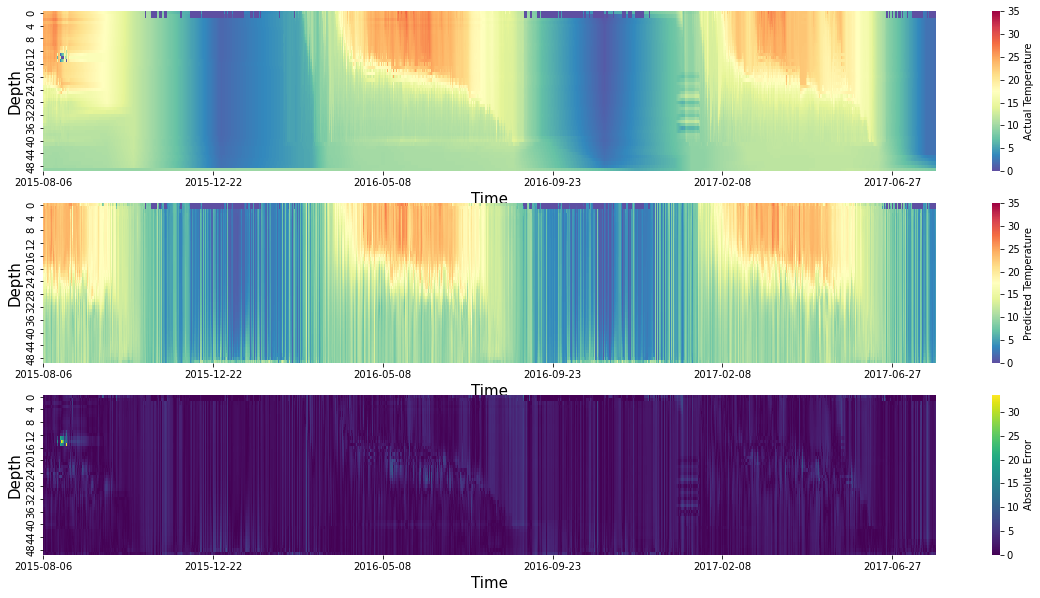

In [22]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

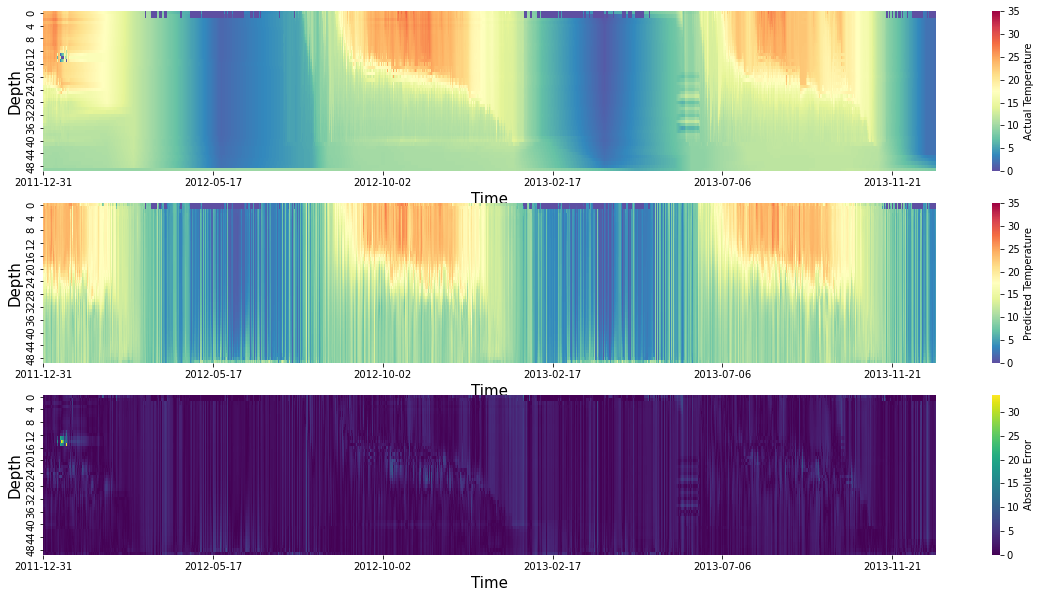

In [23]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [24]:
train_rmse, train_l2_err = compute_metrics( direct_model, train_loader, m0_input_column_ix, m0_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(direct_model, test_loader, m0_input_column_ix, m0_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.8347978875687262, Train L2 Error: 0.0728122532053659
Test RMSE: 2.1011401912782133, Train L2 Error: 0.16971181246686626


## Mixing Model

## Convection Model

## Ice Model

In [25]:
def plot_output_test(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    times = time_label
    
    print(times)
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)


    sns.heatmap(y_pred.T, ax=ax, cmap='Spectral_r', vmin=0., vmax=35.)
    ax.set_ylabel("Depth (m)", fontsize=15)
    ax.set_xlabel("", fontsize=15)
    
    #  plt.legend(fontsize='x-large', title_fontsize='40')
    # ax.xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    # ax.set_xticklabels(time_label, rotation=0)
    # new insert
    xticks_ix = np.array(ax.get_xticks()).astype(int)
    
    print(xticks_ix)
    
    time_label = times[xticks_ix]
    
    print(time_label)
    
    nelement = len(time_label)//N_pts
    
    print(nelement)
    
    time_label = time_label[::nelement]
    
    print(time_label)
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax.set_xticklabels(time_label, rotation=0, fontsize = 15)
    # old code
    ax.collections[0].colorbar.set_label("Predicted Temperature ($^\circ$C)", fontsize = 15)
    yticks_ix = np.array(ax.get_yticks()).astype(int)
    
    print(yticks_ix)
    
    # depth_label = depth_steps / 25
    depth_label = yticks_ix / 2
    
    print(depth_label)
    
    nelement = len(depth_label)//5
    
    print(nelement)
    
    depth_label = depth_label[::nelement]
    
    print(depth_label)
    
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_yticklabels(depth_label, rotation=0, fontsize = 15)

    plt.show()

# Finetuning

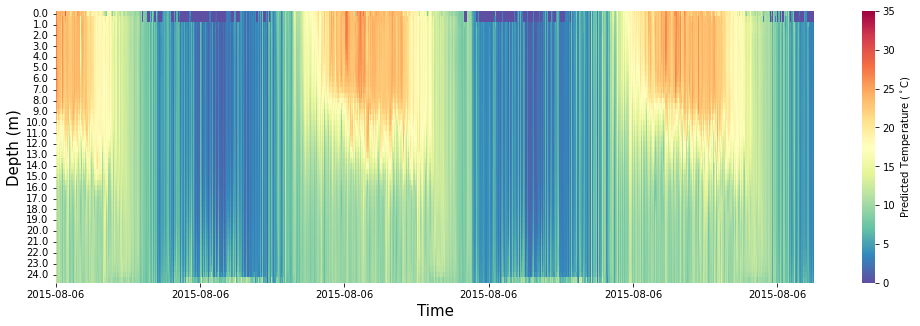

In [26]:
plot_output_test(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(17,5))